In [296]:
%pylab inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pysumma.plotting as psp
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import xarray as xr
import pandas as pd
import pysumma as ps

# function to convert summa
def convert_time_to_summa_string(t):
    return (
        f'{t.dt.year.values[()]:04}'
        f'-{t.dt.month.values[()]:02}'
        f'-{t.dt.day.values[()]:02}'
        f' {t.dt.hour.values[()]:02}'
        f':{t.dt.minute.values[()]:02}'
    )
# set up attributes for forcing data
attrs = {
   'airpres':  {'units': 'Pa', 'long_name': 'Air pressure'},
   'airtemp':  {'units': 'K', 'long_name': 'Air temperature'},
   'spechum':  {'units': 'g g-1', 'long_name': 'Specific humidity'},
   'windspd':  {'units': 'Wind speed', 'long_name': 'm s-1'},
   'SWRadAtm': {'units': 'W m-2', 'long_name': 'Downward shortwave radiation'},
   'LWRadAtm': {'units': 'W m-2', 'long_name': 'Downward longwave radiation'},
   'pptrate':  {'units': 'kg m-2 s-1', 'long_name': 'Precipitation rate'}
}
name_lookup = {
    'airpres':  'pressure_Pa',
    'airtemp':  'temp_K',
    'spechum':  'spechum',
    'windspd':  'windspeed', # Wind_ms
    'SWRadAtm': 'sw', # SW_wm2
    'LWRadAtm': 'LW_wm2',
    'pptrate':  'precip', # precip_mm per hr 'kg m-2 s-1' mm is equivalent to kg/m^2
}

# OPEN FORCING AND WRITE TO NET CDF
df = pd.read_csv('/Users/ianwhidden/pysumma/pysumma/COPY2_run_pysumma/hjandrews_summa_setup/forcings/metstation_WY10_WY15/uplo_forcing_Feb26.csv')
df.index = pd.DatetimeIndex(df['datetime'], name='time')
forcing_filename = 'uplo_station_forcing.nc'
# Adding 1 hour to account for SUMMA being period-ending
time_idx = df.index + pd.Timedelta('1H')
shape = (len(time_idx), 1, )
dims = ('time', 'hru', )
coords = {'time': time_idx}
# Create xarray ds, set coords
met_data = xr.Dataset(coords=coords)
met_data.time.encoding['calendar'] = 'standard'
met_data.time.encoding['units'] = 'hours since 2013-11-01'
for varname, varattrs in attrs.items():
    df_name = name_lookup[varname]
    met_data[varname] = xr.DataArray(
        data=df[df_name].values.reshape(-1, 1),
        coords=coords, dims=dims, name=varname, attrs=varattrs
    )

met_data['pptrate'] /= 3600.0  # Convert from mm/hr to mm/s AKA kg m-2 s-1
# 3600 is timestep xr.variable so it doesnt end up as cords etc
met_data['data_step'] = xr.Variable([], 3600.0)
met_data.to_netcdf(f'./forcings/{forcing_filename}')

with open('./forcings/forcing_file_list.txt', 'w') as f:
    f.write(f"'{forcing_filename}'\n")

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [297]:
# Local attributes

lat = 44.2072180256268
lon = -122.119450090239
elev = 1300
veg = 16
# open local_attributes.nc
local_attrs = xr.open_dataset('/Users/ianwhidden/pysumma/pysumma/COPY2_run_pysumma/hjandrews_summa_setup/params/local_attributes.nc').load()

# Change Xarray dataset (NetCDF) to reflect local_attributes of site AND veg decision
local_attrs['longitude'].values[:] = lon
local_attrs['latitude'].values[:] = lat
local_attrs['elevation'].values[:] = elev
local_attrs['tan_slope'] = 0.0
local_attrs['mHeight'] = 4.5
# 1 is evergreen needleleaf forest in the MODIFIED_IGBP_MODIS_NOAH option
# for the `vegeParTbl` decision. This can be found in the `VEGPARM.TBL` file
# 7 is Open Shrublands
# 16 is Barren or Sparsely Vegetated' ; 13 is Urban

#local_attrs['vegTypeIndex'] = 13
local_attrs['vegTypeIndex'].values[:] = veg

local_attrs.to_netcdf('/Users/ianwhidden/pysumma/pysumma/COPY2_run_pysumma/hjandrews_summa_setup/local_attributes.nc')

In [298]:
local_attrs

<xarray.Dataset>
Dimensions:         (hru: 1, gru: 1)
Dimensions without coordinates: hru, gru
Data variables: (12/14)
    hruId           (hru) int32 1001
    gruId           (gru) int32 1001
    hru2gruId       (hru) int32 1001
    downHRUindex    (hru) int32 0
    longitude       (hru) float64 -122.1
    latitude        (hru) float64 44.21
    ...              ...
    tan_slope       float64 0.0
    contourLength   (hru) float64 100.0
    slopeTypeIndex  (hru) int32 1
    soilTypeIndex   (hru) int32 8
    vegTypeIndex    (hru) int32 16
    mHeight         float64 4.5
Attributes:
    history:  Converted to NetCDF using "../../tools/localAttributes_ascii_to...

In [299]:
!./install_local_setup.sh

summa_exe = 'summa.exe'
file_manager = '/Users/ianwhidden/pysumma/pysumma/COPY2_run_pysumma/hjandrews_summa_setup/file_manager.txt'
# INITIATE (instantiate?) simiulation object
s = ps.Simulation(summa_exe, file_manager)


# modify output, decisions, etc. here, below the instantiation of the simulation object

# Update file manager with start and end time
s.manager['simStartTime'] = '2013-11-01 00:00'
s.manager['simEndTime'] = '2014-06-01 00:00'


## Simulation 1

In [300]:
# summa_exe = 'summa.exe'
# file_manager = '/Users/ianwhidden/pysumma/pysumma/COPY_workspace_HJA_pysumma/hjandrews_summa_setup/file_manager.txt'
# s1 = ps.Simulation(summa_exe, file_manager)
# s1.manager['simStartTime'] = '2013-11-01 00:00'
# s1.manager['simEndTime'] = '2014-06-01 00:00'
# t0 = met_data['time'].isel(time=0)
# t1 = met_data['time'].isel(time=-1)
# s1.manager['simStartTime'] = convert_time_to_summa_string(t0)
# s1.manager['simEndTime'] = convert_time_to_summa_string(t1)
# s1.output_control['scalarSnowDepth'] = [1, 0, 1, 0, 0, 0, 0, 0]
# s1.output_control['scalarSnowAlbedo'] = [1, 0, 1, 0, 0, 0, 0, 0]

In [301]:
# isel grabs first and last time stamp.
t0 = met_data['time'].isel(time=0)
t1 = met_data['time'].isel(time=-1)
s.manager['simStartTime'] = convert_time_to_summa_string(t0)
s.manager['simEndTime'] = convert_time_to_summa_string(t1)

# OUTPUT s
# Add a variable written to the output control file
s.output_control['scalarSnowDepth'] = [1, 0, 1, 0, 0, 0, 0, 0]
s.output_control['scalarSnowAlbedo'] = [1, 0, 1, 0, 0, 0, 0, 0]
#'scalarCanopySnowUnloading' - unloading of snow from the vegetion canopy (kg m-2 s-1)

# OUTPUT s1
# Add a variable written to the output control file
#s1.output_control['scalarSnowDepth'] = [1, 0, 1, 0, 0, 0, 0, 0]
#s1.output_control['scalarSnowAlbedo'] = [1, 0, 1, 0, 0, 0, 0, 0]
#'scalarCanopySnowUnloading' - unloading of snow from the vegetion canopy (kg m-2 s-1)


# DECISIONS s - Parameter values are going to be much more important than the decisions!
# Andreadis et al. 2009 Includes a rapid interception increase between -3 and 0 C
# from observations of increased cohesion in warm regions.
s.decisions['snowIncept']= 'stickySnow'
print(s.decisions['snowIncept'])
#print(s.decisions['snowDenNew'])

#ASK ANDREW
# set the canopy interception option to sparse canopy. summa docs say options are: sparseCanopy, storageFunc, and notPopulatedYet
#s.decisions.set_option('cIntercept', 'sparseCanopy')

#s.decisions['canopySrad']= 
#s.decisions['snowLayers']= 
#s.decisions['thCondSnow']= 

# NEW SNOW DENS - decision doesn't work for now... Why does setting this option not work?
#s.decisions.set_option('snowDenNew', 'anderson')
#print(s.decisions['snowDenNew'])
#s.decisions

# DECISIONS s1
#s1.decisions['snowIncept']= 'stickySnow'
#print(s1.decisions['snowIncept'])
#print(s1.decisions['snowDenNew'])
#s1.decisions.set_option('cIntercept', 'sparseCanopy')


snowIncept    stickySnow           ! choice of parameterization for snow interception


## Parameters

In [302]:
# (5) Model Parameters -  LOCAL PARAMETERS (s.global_hru_params) - set parameters and view those changes AKA local_params.txt

# SNOW
# Max albedo of 0.85 comes from Andreadis et al., 2009
#s.global_hru_params['albedoMax'] = 0.99
s.global_hru_params['albedoSootLoad'] = 0.0
print(s.global_hru_params['albedoSootLoad'])


print(s.global_hru_params['albedoMax'])
print(s.global_hru_params['albedoDecayRate'])
print(s.global_hru_params['albedoRefresh'])


# CANOPY
# roughness length of canopy (m)
# Dont worry too much about this to start
#s.global_hru_params['z0Canopy'] = 

# zero plane displacement / canopy height (-)
# related to turbulent fluxes and wind speed scaling. Dont worry about this.
# s.global_hru_params['zpdFraction'] = 

# height of top of the vegetation canopy above ground 
s.global_hru_params['heightCanopyTop'] = 100
# height of bottom of the vegetation canopy above ground surface (m)
s.global_hru_params['heightCanopyBottom'] = 5
#s.global_hru_params['winterSAI'] = 10
#s.global_hru_params['refInterceptCapSnow'] = 0.1


print(s.global_hru_params['refInterceptCapSnow'])
print(s.global_hru_params['winterSAI'])
print(s.global_hru_params['z0Canopy'])
print(s.global_hru_params['zpdFraction'])
print(s.global_hru_params['heightCanopyTop'])
print(s.global_hru_params['heightCanopyBottom'])

# RADIATION
#s.global_hru_params['Frad_direct'] = 0.99
print(s.global_hru_params['Frad_direct'])
#s.global_hru_params['Frad_vis'] = 0.6
print(s.global_hru_params['Frad_vis'])

# Precipitation partitioning
# critical temperature where precipitation is rain (K)
# 39 F = 277.039 , 36 F = 275.372 k , 32 F = 273.15 K
#s.global_hru_params['tempCritRain']= 275.372
print(s.global_hru_params['tempCritRain'])

# frozen precipitation multiplier (-)
print(s.global_hru_params['frozenPrecipMultip'])

print(s.global_hru_params['refInterceptCapSnow'])

#print(s.global_hru_params)

# PARAMETERS FOR s1
#s1.global_hru_params['heightCanopyTop'] = 30
# height of bottom of the vegetation canopy above ground surface (m)
#s1.global_hru_params['heightCanopyBottom'] = 5

albedoSootLoad            |       0.0000 |       0.0000 |       0.0000
albedoMax                 |       0.8400 |       0.7000 |       0.9500
albedoDecayRate           |       1.0d+6 |       1.0d+5 |       5.0d+6
albedoRefresh             |       1.0000 |       1.0000 |      10.0000
refInterceptCapSnow       |       6.6000 |       1.0000 |      10.0000
winterSAI                 |       1.0000 |       0.0100 |       3.0000
z0Canopy                  |       0.1000 |       0.0010 |      10.0000
zpdFraction               |       0.6500 |       0.5000 |       0.8500
heightCanopyTop           |     100.0000 |     100.0000 |     100.0000
heightCanopyBottom        |       5.0000 |       5.0000 |       5.0000
Frad_direct               |       0.9000 |       0.0000 |       1.0000
Frad_vis                  |       0.9000 |       0.0000 |       1.0000
tempCritRain              |     273.1600 |     272.1600 |     274.1600
frozenPrecipMultip        |       1.0000 |       0.5000 |       1.5000
refInt

In [303]:
s.run('local',run_suffix='base_run')
s.status


'Success'

In [304]:
#print(s.stderr)
#s.reset()
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  n


Nothing done.


In [305]:
# Write something from output to a csv

dssd = s.output['scalarSnowDepth']
df = dssd.to_dataframe()
df = df.to_csv('/Users/ianwhidden/Desktop/thesis_data/summa_output/R4_sd.csv')

dsswe = s.output['scalarSWE']
df = dsswe.to_dataframe()
df = df.to_csv('/Users/ianwhidden/Desktop/thesis_data/summa_output/R4_swe.csv')



<br>

## Plotting

Now that we've got some output we can plot some results. Because the output is an xarray `DataSet` we can use the convenient plotting capabilities provided by xarray.

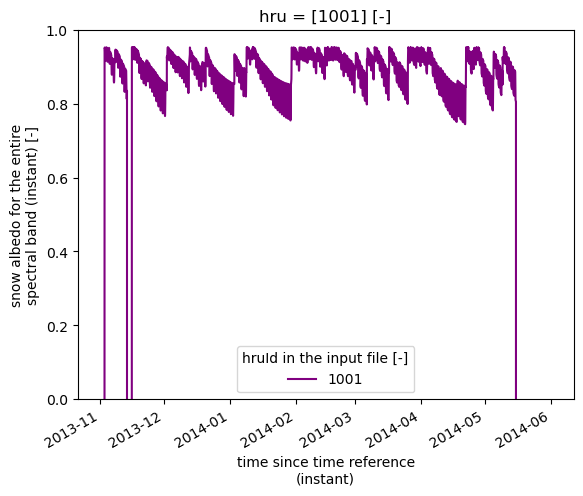

In [306]:
# PLOTS , current is snow albedo

# mass of total water on the vegetation canopy (kg m-2)
#s.output['scalarCanopyWat'].plot(label='SUMMA')

# temperature of each layer (K)
#s.output['mLayerTemp'].plot(label='SUMMA')

#albedo of the ground surface (-)
#s.output['scalarGroundAlbedo'].plot(label='SUMMA')


# Albedo commonly refers to the "whiteness" of a surface, with 0 meaning black and 1 meaning white.
#A value of 0 means the surface is a "perfect absorber" that absorbs all incoming energy.

#snow albedo for the entire spectral band (-)
#s.output['scalarSnowAlbedo'].plot(label='SUMMA')

albedo = s.output['scalarSnowAlbedo']
albedo.plot.line(x='time', color="purple")
# Change the max and min values of plot to show albedo variations
plt.ylim([0, 1])
# Set axis sizes
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10)

#matplotlib.title('Snow Albedo')

#saturation vapor pressure at the temperature of vegetation canopy (Pa)
#s.output['scalarSatVP_CanopyTemp'].plot(label='SUMMA')

#saturation vapor pressure at the temperature of the ground (Pa)
#s.output['scalarSatVP_GroundTemp'].plot(label='SUMMA')

#net radiation (W m-2)
#Graph shows constant net radiation of zero
#s.output['scalarNetRadiation'].plot(label='SUMMA')


#latent heat from the ground (below canopy or non-vegetated) (W m-2)
#s.output['scalarLatHeatGround'].plot(label='SUMMA')


#s.output['scalarLAI'].plot(label='SUMMA')



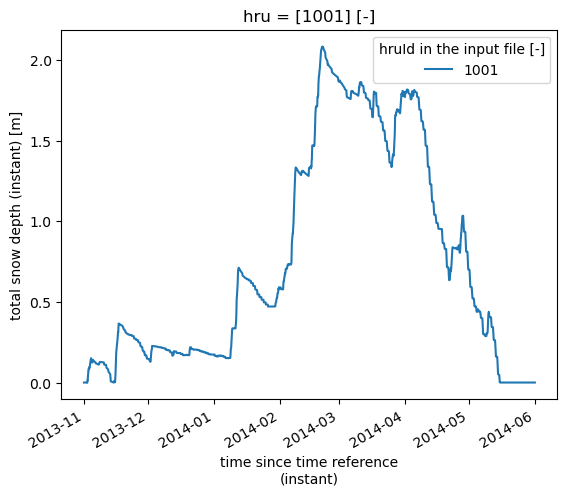

In [307]:
depth = s.output['scalarSnowDepth']
depth.plot.line(x='time',label='Snow depth')
#plt.suptitle('Snow depth')
#depth.title('Depth')
#plt.plot(s.output['scalarSnowDepth'], x='time')
#from matplotlib import pyplot as plt    

#fig = plt.figure()
#plt.plot(s.output['scalarSnowDepth'])
#plt.suptitle('Snowpack depth', fontsize=20)

#plt.xlabel('Time', fontsize=18)
#plt.ylabel('Snowpack depth m', fontsize=16)
#fig.savefig('test.jpg')

<xarray.DataArray 'scalarSurfaceTemp' (time: 5089, hru: 1)>
array([[32.26442561],
       [32.26846166],
       [32.27157601],
       ...,
       [53.40932697],
       [51.7833165 ],
       [50.63130742]])
Coordinates:
  * time     (time) datetime64[ns] 2013-11-01T00:59:59.999986688 ... 2014-06-...
  * hru      (hru) int64 1001


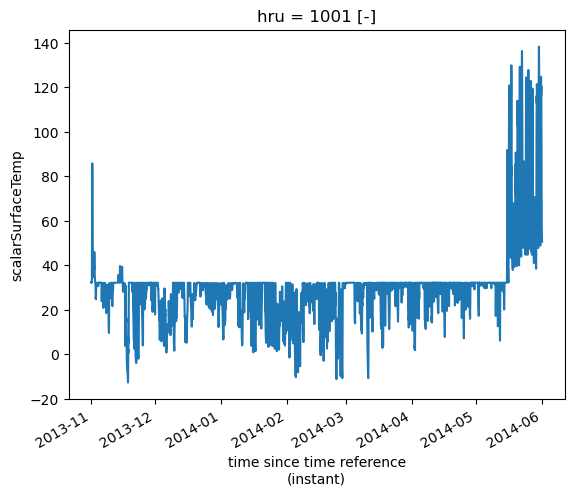

In [308]:
# PLOT TEMP IN FARENHEIT - prognostic (predicted by model) - scalarSurfaceTemp is the temp of the ground surface
temp = s.output['scalarSurfaceTemp']

# Convert
temp_f = 1.8*(temp-273) + 32
print(temp_f)
#s.output['scalarSurfaceTemp'].plot(label='SUMMA');
temp_f.plot(label='temp_F')

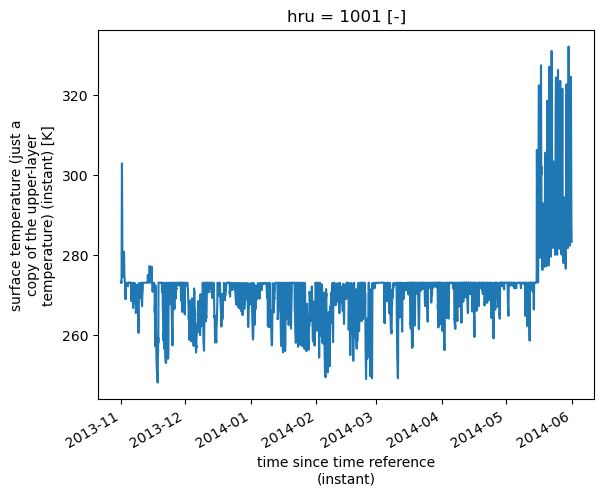

In [309]:
s.output['scalarSurfaceTemp'].plot(label='SUMMA');

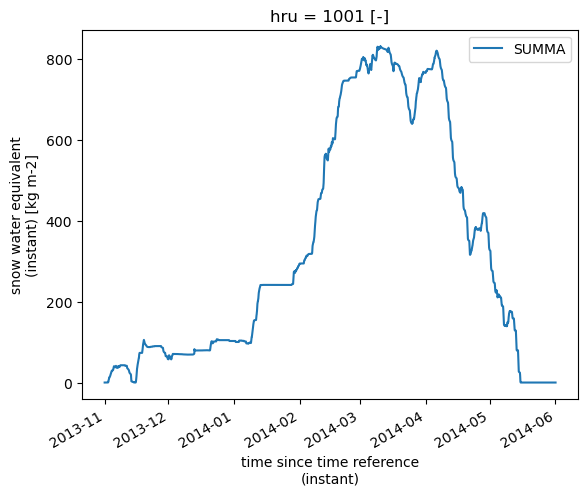

In [310]:
# plot for SWE

s.output['scalarSWE'].plot(label='SUMMA');
#s.output['scalarSnowDepth'].plot(label='SUMMA');
plt.legend();

In [311]:
# plot for something else
"""
s.output['scalarSurfaceTemp'].plot(label='SUMMA');
#s.output['scalarSnowDepth'].plot(label='SUMMA');
plt.legend();
"""
#s.output_control
#s.output['scalarSnowAlbedo'].plot(color='red', linewidth=2);
s.output

<xarray.Dataset>
Dimensions:                    (time: 5089, hru: 1, midToto: 14, midSoil: 9,
                                ifcToto: 15, gru: 1)
Coordinates:
  * time                       (time) datetime64[ns] 2013-11-01T00:59:59.9999...
  * hru                        (hru) int64 1001
  * gru                        (gru) int64 1001
Dimensions without coordinates: midToto, midSoil, ifcToto
Data variables: (12/42)
    scalarCanopyWat            (time, hru) float64 ...
    scalarSnowAlbedo           (time, hru) float64 ...
    scalarSnowDepth            (time, hru) float64 ...
    scalarSWE                  (time, hru) float64 ...
    mLayerTemp                 (time, midToto, hru) float64 ...
    mLayerVolFracWat           (time, midToto, hru) float64 ...
    ...                         ...
    scalarCanopyEvaporation    (time, hru) float64 ...
    scalarGroundEvaporation    (time, hru) float64 ...
    scalarTotalRunoff          (time, hru) float64 ...
    scalarNetRadiation         (time, hru) float64 ...
    hruId                      (hru) int64 ...
    gruId                      (gru) int64 ...
Attributes: (12/40)
    summaVersion:     v3.1.0
    buildTime:        Thu Sep  8 20:37:09 UTC 2022
    gitBranch:        tags/v3.1.0-0-g372c3fb
    gitHash:          372c3fbeb3825e3b3d635461a8e552f9f0895aec
    soilCatTbl:       ROSETTA
    vegeParTbl:       MODIFIED_IGBP_MODIS_NOAH
    ...               ...
    snowLayers:       CLM_2010
    compaction:       anderson
    thCondSnow:       jrdn1991
    thCondSoil:       funcSoilWet
    spatial_gw:       localColumn
    subRouting:       qInstant

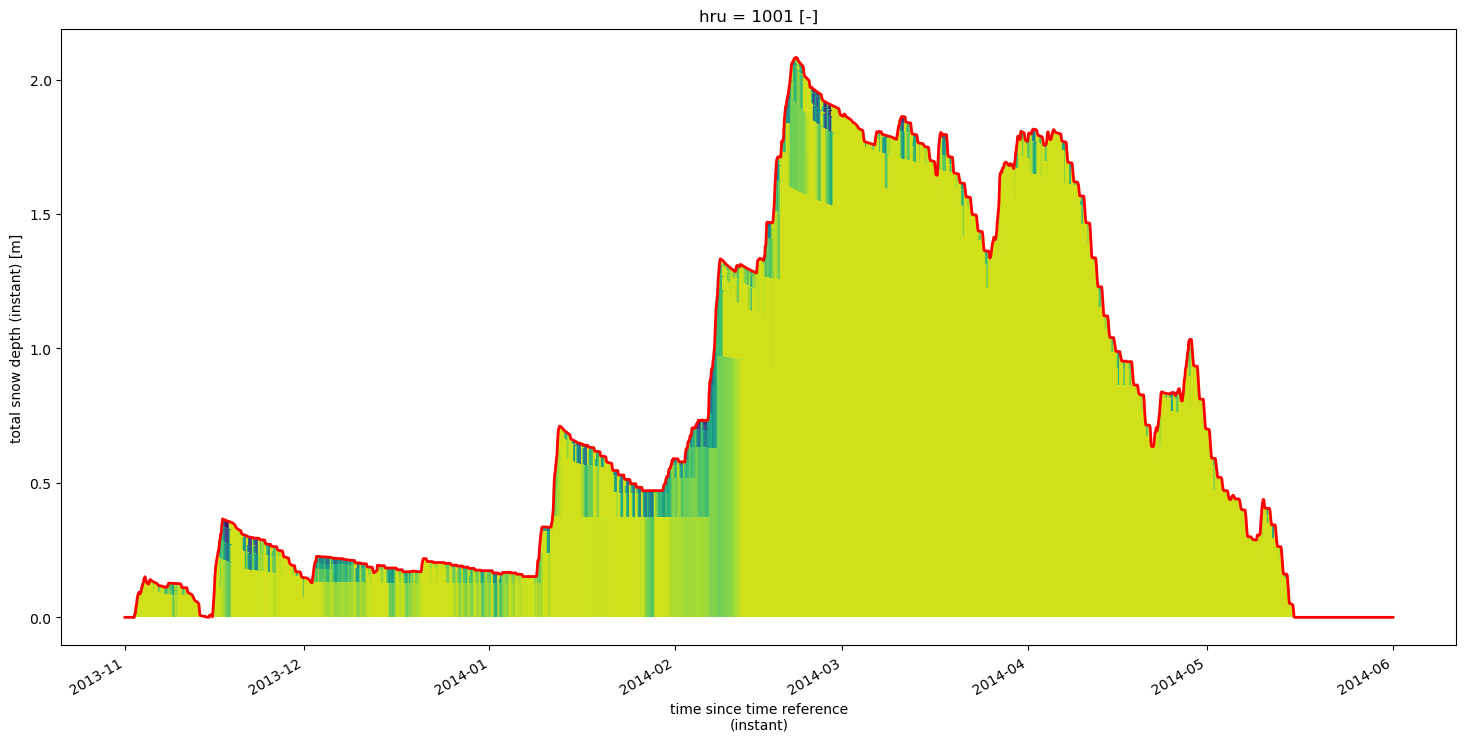

In [312]:
# s.output[whichever cell/data]

# Total snow depth
depth = s.output.isel(hru=0)['iLayerHeight']
temp = s.output.isel(hru=0)['mLayerTemp']
frac_wat = s.output.isel(hru=0)['mLayerVolFracWat']

psp.layers(temp, depth, colormap='viridis', plot_soil=False, plot_snow=True);
s.output['scalarSnowDepth'].plot(color='red', linewidth=2);



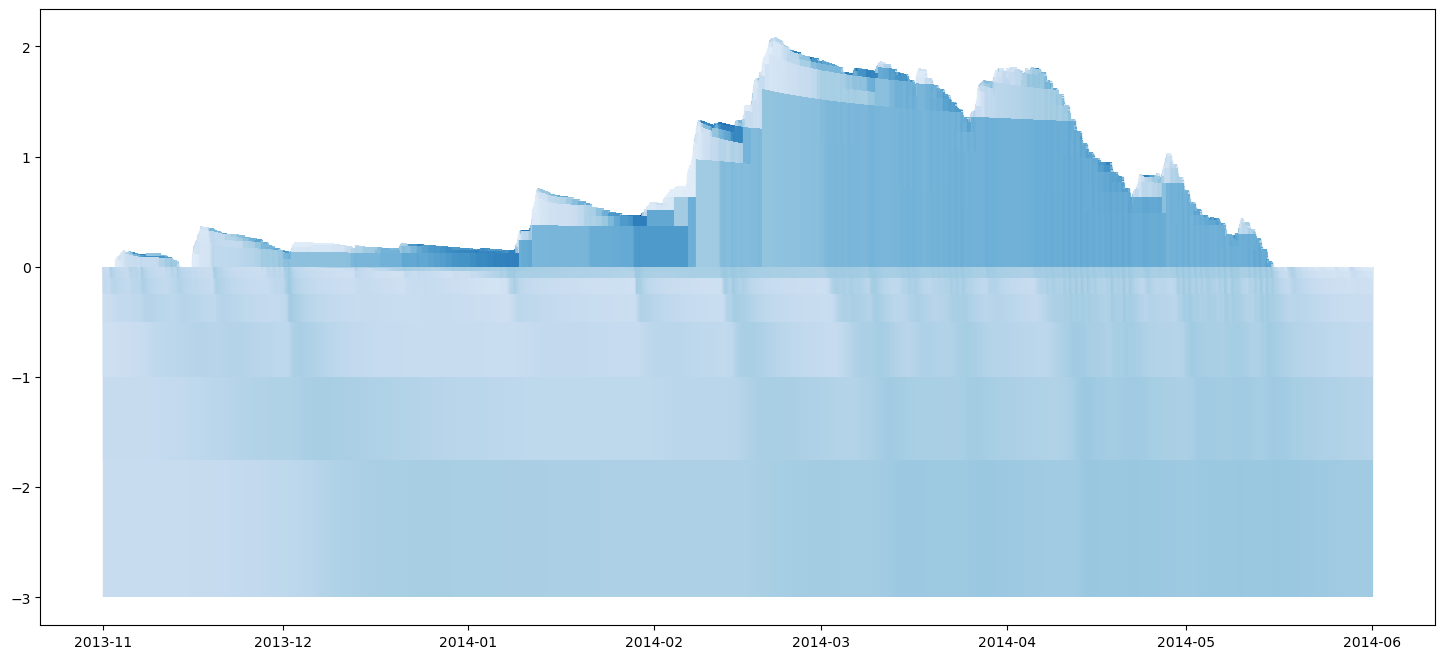

In [313]:
# Volumetric water content

psp.layers(frac_wat, depth, colormap='Blues', plot_soil=True, plot_snow=True);
#s.output['scalarSnowDepth'].plot(color='red', linewidth=2);

# Change what is written in s.output_control (txt)

In [314]:
# Add a variable written to output

"""s.output_control['scalarSnowDepth'] = {
    'period': 1, 'instant': 1, 'sum': 0, 
    'mean': 0, 'variance': 0, 'min': 0, 'max': 0}
    """
#s.output_control['scalarSnowDepth']


"s.output_control['scalarSnowDepth'] = {\n    'period': 1, 'instant': 1, 'sum': 0, \n    'mean': 0, 'variance': 0, 'min': 0, 'max': 0}\n    "

## s.decisions (txt)

In [315]:
#print(s.decisions)

In [316]:
# Get just the `snowIncept` option
#print(s.decisions['snowIncept'])
#print(s.decisions['windPrfile'])

print(s.decisions['windPrfile'].available_options)

# Change the value of a decision example
#s.decisions['snowIncept'] = 'stickySnow'
#print(s.decisions['snowIncept'])

['exponential', 'logBelowCanopy']
